# Creación de Gráfica

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path

import streamlit as st
from modelo import *
import requests
from bs4 import BeautifulSoup
from io import StringIO
from urllib.request import urlopen
from matplotlib.gridspec import GridSpec

import statsmodels.api as sm
from scipy.stats import poisson

poisson_model_int = sm.load('data/poisson_model_fpc.pickle')


headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
ligas={
    'Colombia - Liga Bet Play':217,
    'Colombia - Torneo Bet Play':407,
    'Argentina - Torneo 2021':5334,
    'Mexico - Liga MX':108,
    'Estados Unidos - MLS':41,
    'Internacional - Copa Libertadores':184
}
temporadas={
    '2021':27,
    '2022':29
}
season_2021=27
season_2022=29

In [2]:
def extract_matches(tournament_id,season_id):
    url=f'http://service.instatfootball.com/feed.php?id=819845&key=T4bwoXqr&tpl=35&tournament_id={tournament_id}&season_id={season_id}&date_start=2021-07-01&date_end=&lang_id=1&lang=en&format=csv'
    try:
        response=requests.get(url,headers=headers)
        soup=BeautifulSoup(response.content,'lxml')
        s= soup.get_text()
        f = StringIO(s)
        df =pd.read_csv(f,sep=';')
        return df
    except requests.exceptions.RequestException as e:
        print(e)
        exit()
def show_match_events(match_id):
    url=f'http://service.instatfootball.com/feed.php?id=819845&key=T4bwoXqr&tpl=36&start_ms=0&match_id={match_id}&lang_id=1&lang=en&format=csv'
    try:
        response=requests.get(url,headers=headers)
        soup=BeautifulSoup(response.content,'lxml')
        s= soup.get_text()
        f = StringIO(s)
        df =pd.read_csv(f,sep=';')
        return df
    except requests.exceptions.RequestException as e:
        print(e)
        exit()

In [4]:
part_21=extract_matches(217,27)
part_22=extract_matches(217,29)

part_21=part_21[part_21['available_events']==True]
part_22=part_22[part_22['available_events']==True]

parts=part_21.append(part_22,ignore_index=True)


In [6]:
list_21=part_21.loc[part_21.round_name.isin(['Week 39','Week 38','Week 37']),'id'].tolist()
list_22=part_22['id'].unique().tolist()
lista_ids=list_21+list_22

In [22]:
df=pd.DataFrame()
for idx in lista_ids:
    try:
        temp=pd.read_csv(f'DataApi/{idx}.csv')
    except:
        temp=show_match_events(idx)
    temp['match_date']=parts.loc[parts['id']==idx,'match_date'].values[0]
    temp['match_id']=idx
    df=df.append(temp,ignore_index=True)

tiros=['Shot on target', 'Shot into the bar/post', 'Shot blocked', 'Shot blocked by field player', 'Goal', 'Wide shot']
x_tot=105
y_der=24.85
y_izq=43.15
y_centro=34

b=[ -1.2111 , 0.6653, -0.1039 ]

df['numerador']=(x_tot-df['pos_x'])*(x_tot-df['pos_x'])+(y_izq-df['pos_y'])*(y_der-df['pos_y'])
df['denominador']=np.sqrt((x_tot-df['pos_x'])**2 + (y_der-df['pos_y'])**2 ) * np.sqrt((x_tot-df['pos_x'])**2 + (y_izq-df['pos_y'])**2)
df['angulo']=np.arccos(df['numerador']/df['denominador'])
df['distancia']=np.sqrt((x_tot-df['pos_x'])**2+(y_centro-df['pos_y'])**2)
df['Suma'] = -b[0]-b[1]*df['angulo']-b[2]*df['distancia']
df['xG']=0
df.loc[df['action_name'].isin(tiros),'xG'] = df.loc[df['action_name'].isin(tiros),'Suma'].apply(lambda x:1/(1+np.exp(x)))

In [31]:
df_xg=df.groupby(['match_date','match_id','team_name']).sum()['xG'].reset_index()
df_xg['Op xG']=0
for idx,row in df_xg.iterrows():
    equipo=row['team_name']
    match_id=row['match_id']
    df_xg.loc[(df_xg['match_id']==match_id)&(df_xg['team_name']!=equipo),'Op xG']=row['xG']

df_xg=df_xg.sort_values('match_date')
df_xg['cumxG_propio'] = df_xg.groupby(['team_name'])['xG'].apply(lambda x: x.shift().rolling(3).mean())
df_xg['cumxG_contrario'] = df_xg.groupby(['team_name'])['Op xG'].apply(lambda x: x.shift().rolling(3).mean())
df_xg[df_xg['team_name']=='Independiente Santa Fe']

,match_date,match_id,team_name,xG,Op xG,cumxG_propio,cumxG_contrario
13,2021-11-08 00:00:00,1971289,Independiente Santa Fe,2.157439,0.194142,NaN,NaN
32,2021-11-16 04:05:00,1971301,Independiente Santa Fe,0.842281,0.953512,NaN,NaN
41,2021-11-21 03:00:00,1971302,Independiente Santa Fe,2.375618,0.407014,NaN,NaN
60,2022-01-22 02:00:00,2178812,Independiente Santa Fe,1.227157,1.058525,1.791780,0.518223
79,2022-01-26 02:05:00,2179144,Independiente Santa Fe,1.472341,1.307107,1.481685,0.806350
97,2022-01-29 22:00:00,2179293,Independiente Santa Fe,1.935904,1.937902,1.691705,0.924215
123,2022-02-03 04:15:00,2180731,Independiente Santa Fe,0.991221,0.889105,1.545134,1.434511


In [53]:
for idx, row in part_22.iterrows():
    id=row['id']
    team1=row['team1_name']
    team2=row['team2_name']
    part_22.loc[(part_22['id']==id),'team1_xG']=df_xg.loc[(df_xg['match_id']==id)&(df_xg['team_name']==team1),'cumxG_propio'].values[0]
    part_22.loc[(part_22['id']==id),'team2_xG']=df_xg.loc[(df_xg['match_id']==id)&(df_xg['team_name']==team2),'cumxG_propio'].values[0]
    part_22.loc[(part_22['id']==id),'team1_xG_op']=df_xg.loc[(df_xg['match_id']==id)&(df_xg['team_name']==team1),'cumxG_contrario'].values[0]
    part_22.loc[(part_22['id']==id),'team2_xG_op']=df_xg.loc[(df_xg['match_id']==id)&(df_xg['team_name']==team2),'cumxG_contrario'].values[0]


In [51]:
def simulate_match(foot_model,xG_local,xG_perm_local, xG_visitante,xG_perm_visitante,casa=True, max_goals=5):
    if casa==True:
        home_goals_avg = foot_model.predict(pd.DataFrame(data={'cumxG_propio': xG_local,  'cumxG_contrario_equipo2':xG_perm_visitante,'Home':1},index=[1])).values[0]
    else:
        home_goals_avg = foot_model.predict(pd.DataFrame(data={'cumxG_propio': xG_local,  'cumxG_contrario_equipo2':xG_perm_visitante,'Home':0},index=[1])).values[0]     
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'cumxG_propio': xG_visitante, 'cumxG_contrario_equipo2':xG_perm_local,'Home':0},index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

def probabilidades(xG_local,xG_perm_local, xG_visitante,xG_perm_visitante,casa=True, max_goals=5,foot_model=poisson_model_int):
    partido=simulate_match(foot_model,xG_local,xG_perm_local, xG_visitante,xG_perm_visitante,casa, max_goals)
    series=pd.Series([1-np.sum(np.triu(partido, 1))-np.sum(np.diag(partido)),np.sum(np.diag(partido)),np.sum(np.triu(partido, 1))],index=['Local','Empate','Visitante'])
    return series


In [72]:
part_22[['team1_xG','team1_xG_op','team2_xG','team2_xG_op']]=part_22[['team1_xG','team1_xG_op','team2_xG','team2_xG_op']].fillna(part_22[['team1_xG','team1_xG_op','team2_xG','team2_xG_op']].quantile(.05))

In [74]:
part_22[['Prob L','Prob E','Prob V']]=np.round(part_22.apply(lambda x: probabilidades(x['team1_xG'],x['team1_xG_op'],x['team2_xG'],x['team2_xG_op']),axis=1),2)

In [77]:
df_probabilidades=part_22[['id','match_date','team1_name','team1_score','team2_score','team2_name','Prob L','Prob E','Prob V']]

In [81]:
df_eq=df_probabilidades[(df_probabilidades['team1_name']=='Atletico Nacional')|(df_probabilidades['team2_name']=='Atletico Nacional')]
df_eq['Probabilidad Ganar']=df_eq.apply(lambda x: x['Prob L'] if x['team1_name']=='Atletico Nacional' else x['Prob V'],axis=1)

<ipython-input-81-6c12344a436b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eq['Probabilidad Ganar']=df_eq.apply(lambda x: x['Prob L'] if x['team1_name']=='Atletico Nacional' else x['Prob V'],axis=1)


In [86]:
df_eq

,id,match_date,team1_name,team1_score,team2_score,team2_name,Prob L,Prob E,Prob V,Probabilidad Ganar
236,2179778,2022-01-30 04:15:00,Millonarios,0,2,Atletico Nacional,0.50,0.26,0.24,0.24
243,2179187,2022-01-27 04:15:00,Atletico Nacional,3,1,CD Popular Junior FC SA,0.36,0.28,0.36,0.36
255,2178874,2022-01-23 00:05:00,Cortulua,1,1,Atletico Nacional,0.40,0.30,0.30,0.30


In [99]:
df_eq['Partido']=df_eq['team1_name']+' '+df_eq['team1_score'].map(str)+' - '+df_eq['team2_score'].map(str)+' '+df_eq['team2_name']

<ipython-input-99-052eaae68fde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eq['Partido']=df_eq['team1_name']+' '+df_eq['team1_score'].map(str)+' - '+df_eq['team2_score'].map(str)+' '+df_eq['team2_name']


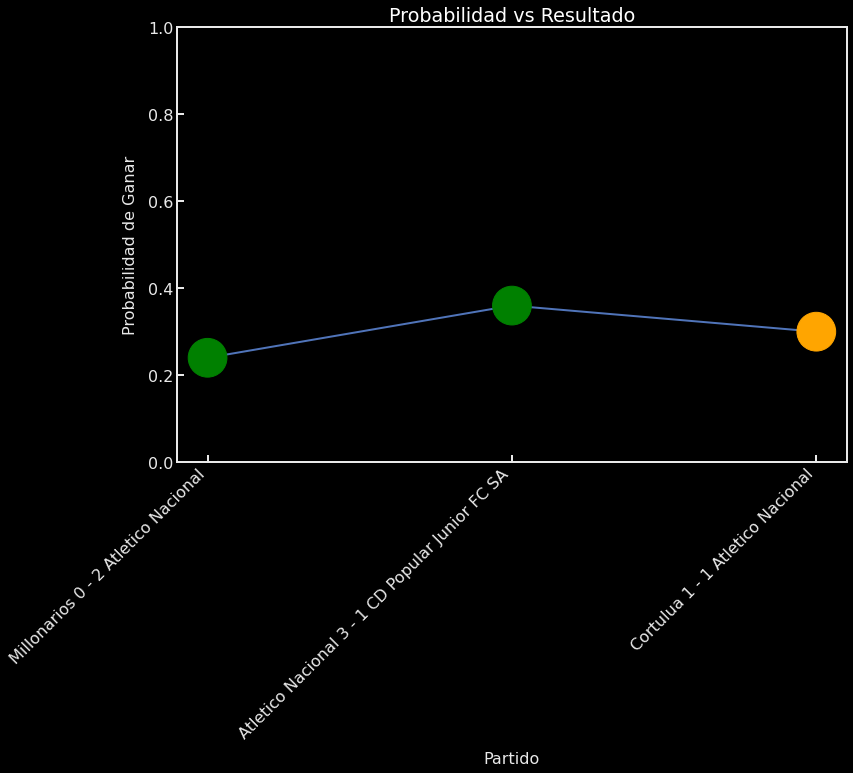

In [116]:
plt.plot(df_eq['Partido'],df_eq['Probabilidad Ganar'])
plt.scatter(df_eq['Partido'],df_eq['Probabilidad Ganar'],s=1500,color=['green','green','orange'],zorder=30)
plt.xticks(rotation=45,ha='right')
plt.ylim(0,1)
plt.title("Probabilidad vs Resultado")
plt.xlabel("Partido")
plt.ylabel("Probabilidad de Ganar")
plt.show()

## Gráfica estadísticas

In [4]:
#df_fidos=df_f_22.append(part_21,ignore_index=True)

In [ ]:
for _,idx in enumerate(part_22['id'].unique()):
    my_file = Path(f"DataApi/{str(idx)}.csv")
    if my_file.is_file():
        print(f"{_} ok {idx}")
    else:
        try:
            print(f"{_} Descargando {idx}...")
            df=show_match_events(idx)
            df.to_csv(f'DataApi/{idx}.csv')
            print(f"{_} {idx} Descargado.")
        except:
            print(f"{_} Fallo descargando {idx}.")

In [51]:
df=pd.DataFrame()
for idx in part_22['id'].unique():
    temp=pd.read_csv(f'DataApi/{idx}.csv')
    temp['match_id']=str(idx)
    temp['jornada']=int(part_22.loc[part_22['id']==idx,'round_id'].values[0])
    df=df.append(temp,ignore_index=True)

In [52]:
tiros=['Shot on target', 'Shot into the bar/post', 'Shot blocked', 'Shot blocked by field player', 'Goal', 'Wide shot']
x_tot=105
y_der=24.85
y_izq=43.15
y_centro=34

b=[ -1.2111 , 0.6653, -0.1039 ]

df['numerador']=(x_tot-df['pos_x'])*(x_tot-df['pos_x'])+(y_izq-df['pos_y'])*(y_der-df['pos_y'])
df['denominador']=np.sqrt((x_tot-df['pos_x'])**2 + (y_der-df['pos_y'])**2 ) * np.sqrt((x_tot-df['pos_x'])**2 + (y_izq-df['pos_y'])**2)
df['angulo']=np.arccos(df['numerador']/df['denominador'])
df['distancia']=np.sqrt((x_tot-df['pos_x'])**2+(y_centro-df['pos_y'])**2)
df['Suma'] = -b[0]-b[1]*df['angulo']-b[2]*df['distancia']
df['xG']=0
df.loc[df['action_name'].isin(tiros),'xG'] = df.loc[df['action_name'].isin(tiros),'Suma'].apply(lambda x:1/(1+np.exp(x)))

In [53]:
set_pieces=['Accurate crossing from set piece with a goal','Set piece cross with goal','Accurate crossing from set piece with a shot','Misplaced crossing from set piece with a shot','Misplaced crossing from set piece with a goal']

In [54]:
df['prev_action']=df['action_name'].shift()
df['prevprev_action']=df['action_name'].shift(2)
df['prevprevprev_action']=df['action_name'].shift(3)

In [55]:
mask=(df['action_name'].isin(tiros))&((df['prev_action'].isin(set_pieces))|(df['prevprev_action'].isin(set_pieces))|(df['prevprevprev_action'].isin(set_pieces)))
mask1=(df['action_name'].isin(tiros))&((df['prev_action']=='Accurate key pass')|(df['prevprev_action']=='Accurate key pass')|(df['prevprevprev_action']=='Accurate key pass'))
df['xG_from setpiece']=0
df.loc[mask,'xG_from setpiece']=df.loc[mask,'xG']
df['key_passes']=(df['action_name']=='Accurate key pass').astype(int)
df['xG_from_keypass']=0
df.loc[mask,'xG_from_keypass']=df.loc[mask1,'xG']


In [56]:
df_f=df.groupby(['jornada','match_id','team_name']).sum()[['xG','xG_from setpiece','key_passes','xG_from_keypass']].reset_index()
df_f['xG (Contrario)']=0
df_f['xG_from setpiece (Contrario)']=0
df_f['key_passes (Contrario)']=0
for idx,row in df_f.iterrows():
    equipo=row['team_name']
    match_id=row['match_id']
    df_f.loc[(df_f['match_id']==match_id)&(df_f['team_name']!=equipo),'xG (Contrario)']=row['xG']
    df_f.loc[(df_f['match_id']==match_id)&(df_f['team_name']!=equipo),'xG_from setpiece (Contrario)']=row['xG_from setpiece']
    df_f.loc[(df_f['match_id']==match_id)&(df_f['team_name']!=equipo),'key_passes (Contrario)']=row['key_passes']

df_f

,jornada,match_id,team_name,xG,xG_from setpiece,key_passes,xG_from_keypass,xG (Contrario),xG_from setpiece (Contrario),key_passes (Contrario)
0,1,2178779,America de Cali,1.586516,0.113305,4,0.000000,0.290558,0.000000,2
1,1,2178779,Envigado,0.290558,0.000000,2,0.000000,1.586516,0.113305,4
2,1,2178780,Aguilas Doradas,1.022191,0.195541,1,0.000000,1.705674,0.319748,5
3,1,2178780,Atletico Bucaramanga,1.705674,0.319748,5,0.000000,1.022191,0.195541,1
4,1,2178812,Independiente Santa Fe,1.227157,0.000000,1,0.000000,1.058525,0.317512,1
5,1,2178812,La Equidad,1.058525,0.317512,1,0.000000,1.227157,0.000000,1
6,1,2178874,Atletico Nacional,1.287640,0.303041,3,0.000000,0.962078,0.016357,0
7,1,2178874,Cortulua,0.962078,0.016357,0,0.000000,1.287640,0.303041,3
8,1,2178875,Deportivo Pasto,0.600962,0.000000,2,0.000000,1.687123,0.104444,2
9,1,2178875,Millonarios,1.687123,0.104444,2,0.000000,0.600962,0.000000,2


In [81]:
equipo='CD Popular Junior FC SA'
columna='xG_from setpiece'
def barra_eq(df_f,equipo,columna):
    fig2=plt.figure(figsize=(10,2))
    per25=np.percentile(df_f.groupby('team_name').mean()[columna],25)
    per50=np.percentile(df_f.groupby('team_name').mean()[columna],50)
    per75=np.percentile(df_f.groupby('team_name').mean()[columna],75)
        

    plt.axvspan(0, per25, color='red', alpha=0.5)
    plt.axvspan(per25, per50, color='orange', alpha=0.5)
    plt.axvspan(per50, per75, color='yellow', alpha=0.5)
    plt.axvspan(per75, df_f[columna].max()+1, color='green', alpha=0.5)

    for idx,row in df_f.groupby('team_name').mean().iterrows():
        eq=idx
        xg=row[columna]
        if eq==equipo:
            plt.scatter(row[columna],1,color='white',s=200,zorder=11,label="Promedio Temporada")
        else:
            plt.scatter(row[columna],1,color='grey',zorder=10)
    plt.title(f"{columna}")
    plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = True, bottom = True)
    plt.axvline(x=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0],linestyle='--',color='white',zorder=10,label="Ultimo partido")
    plt.axvspan(0, per25, color='red', alpha=0.5)

    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].min():
        xop_min2= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] - 0.05
    else:
        xop_min2=df_f.groupby('team_name').mean()[columna].min() - 0.05
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].max():
        xop_max2=df_f.groupby('team_name').mean()[columna].max() + 0.05
    else:
        xop_max2= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] + 0.05
    plt.legend()
    plt.xlim((0,xop_max2))
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    plt.show()

In [77]:
equipo='CD Popular Junior FC SA'
columna='xG (Contrario)'
def barra_op(df_f,equipo,columna):
    fig2=plt.figure(figsize=(10,2))
    per25=np.percentile(df_f.groupby('team_name').mean()[columna],25)
    per50=np.percentile(df_f.groupby('team_name').mean()[columna],50)
    per75=np.percentile(df_f.groupby('team_name').mean()[columna],75)
        

    plt.axvspan(per25, per50, color='yellow', alpha=0.5)
    plt.axvspan(per50, per75, color='orange', alpha=0.5)
    plt.axvspan(per75, df_f[columna].max()+1, color='red', alpha=0.5)

    for idx,row in df_f.groupby('team_name').mean().iterrows():
        eq=idx
        xg=row[columna]
        if eq==equipo:
            plt.scatter(row[columna],1,color='white',s=200,zorder=11,label="Promedio Temporada")
        else:
            plt.scatter(row[columna],1,color='grey',zorder=10)

    plt.title(f"{columna}")
    plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = True, bottom = True)
    plt.axvline(x=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0],linestyle='--',color='white',zorder=10,label='Ultimo partido')
    plt.axvspan(0, per25, color='green', alpha=0.5)
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].min():
        xop_min= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] - 0.05
    else:
        xop_min=df_f.groupby('team_name').mean()[columna].min() - 0.05
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].max():
        xop_max= df_f.groupby('team_name').mean()[columna].max() + 0.05
    else:
        xop_max=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] + 0.05
    plt.xlim((xop_min,xop_max))
    plt.gca().invert_xaxis()
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

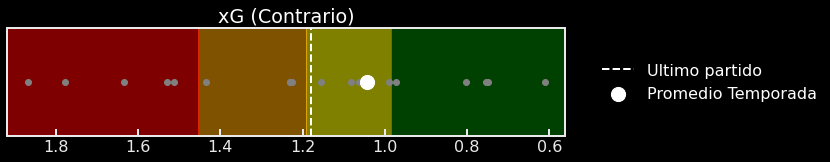

In [78]:
barra_op(df_f,'Envigado','xG (Contrario)')

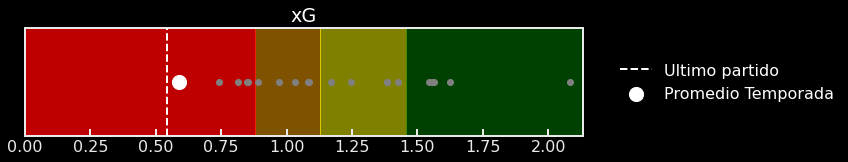

In [82]:
barra_eq(df_f,'Envigado','xG')

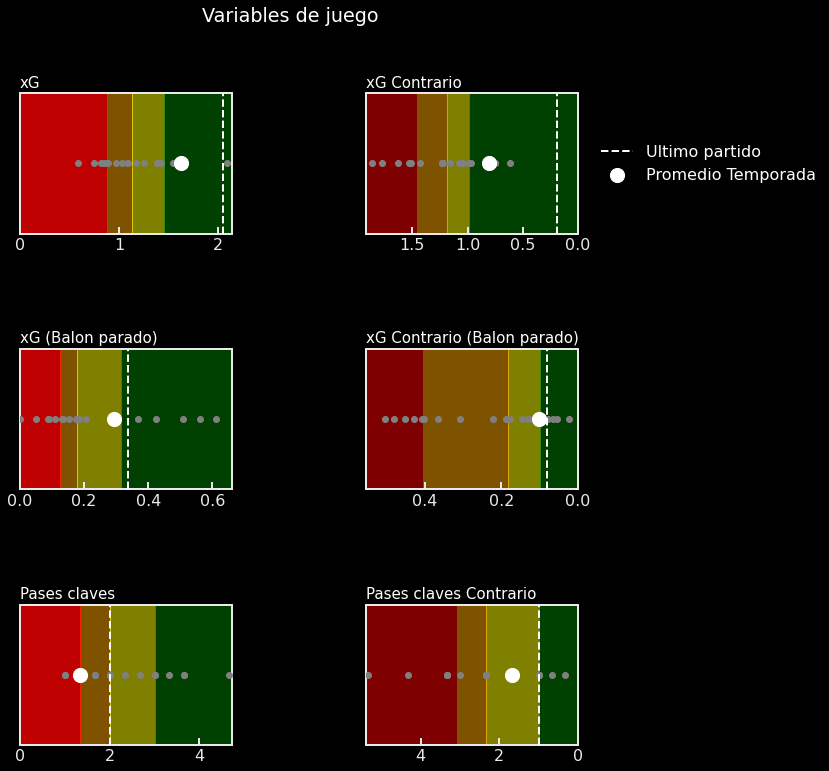

In [173]:
equipo='CD Popular Junior FC SA'
columna='xG (Contrario)'
nombres_columnas={
    'xG':'xG', 
    'xG (Contrario)':'xG Contrario',
    'xG_from setpiece':'xG (Balon parado)',
    'xG_from setpiece (Contrario)':'xG Contrario (Balon parado)',
    'key_passes':'Pases claves',
    'key_passes (Contrario)':'Pases claves Contrario',
}
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(nrows=5, ncols=5,height_ratios=[1,0.5, 1,0.5, 1])
#width_ratios=[1, 1], height_ratios=[1, 1, 1]

ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[0, 3:])
ax2 = fig.add_subplot(gs[2, 0:2])
ax3 = fig.add_subplot(gs[2, 3:])
ax4 = fig.add_subplot(gs[4, 0:2])
ax5 = fig.add_subplot(gs[4, 3:])


def axis_op(df_f,equipo,columna,ax):
    per25=np.percentile(df_f.groupby('team_name').mean()[columna],25)
    per50=np.percentile(df_f.groupby('team_name').mean()[columna],50)
    per75=np.percentile(df_f.groupby('team_name').mean()[columna],75)
        

    ax.axvspan(per25, per50, color='yellow', alpha=0.5)
    ax.axvspan(per50, per75, color='orange', alpha=0.5)
    ax.axvspan(per75, df_f[columna].max()+1, color='red', alpha=0.5)
    ax.axvspan(0, per25, color='green', alpha=0.5)

    for idx,row in df_f.groupby('team_name').mean().iterrows():
        eq=idx
        xg=row[columna]
        if eq==equipo:
            ax.scatter(row[columna],1,color='white',s=200,zorder=11,label="Promedio Temporada")
        else:
            ax.scatter(row[columna],1,color='grey',zorder=10)

    ax.set_title(f"{nombres_columnas[columna]}",loc='left',fontsize=15)
    ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = True, bottom = True)
    ax.axvline(x=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0],linestyle='--',color='white',zorder=10,label='Ultimo partido')
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].min():
        xop_min= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] - 0.05
    else:
        xop_min=df_f.groupby('team_name').mean()[columna].min() - 0.05
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].max():
        xop_max= df_f.groupby('team_name').mean()[columna].max() + 0.05
    else:
        xop_max=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] + 0.05
    ax.set_xlim((0,xop_max))
    ax.set_xlim(ax.get_xlim()[::-1])

def axis_eq(df_f,equipo,columna,ax):
    per25=np.percentile(df_f.groupby('team_name').mean()[columna],25)
    per50=np.percentile(df_f.groupby('team_name').mean()[columna],50)
    per75=np.percentile(df_f.groupby('team_name').mean()[columna],75)
        

    ax.axvspan(0, per25, color='red', alpha=0.5)
    ax.axvspan(per25, per50, color='orange', alpha=0.5)
    ax.axvspan(per50, per75, color='yellow', alpha=0.5)
    ax.axvspan(per75, df_f[columna].max()+1, color='green', alpha=0.5)

    for idx,row in df_f.groupby('team_name').mean().iterrows():
        eq=idx
        xg=row[columna]
        if eq==equipo:
            ax.scatter(row[columna],1,color='white',s=200,zorder=11,label="Promedio Temporada")
        else:
            ax.scatter(row[columna],1,color='grey',zorder=10)
    ax.set_title(f"{nombres_columnas[columna]}",loc='left',fontsize=15)
    ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = True, bottom = True)
    ax.axvline(x=df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0],linestyle='--',color='white',zorder=10,label="Ultimo partido")
    ax.axvspan(0, per25, color='red', alpha=0.5)

    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].min():
        xop_min2= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] - 0.05
    else:
        xop_min2=df_f.groupby('team_name').mean()[columna].min() - 0.05
    if df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] < df_f.groupby('team_name').mean()[columna].max():
        xop_max2=df_f.groupby('team_name').mean()[columna].max() + 0.05
    else:
        xop_max2= df_f.loc[(df_f['jornada']==df_f.loc[df_f['team_name']==equipo,'jornada'].max())&(df_f['team_name']==equipo),columna].values[0] + 0.05
    
    ax.set_xlim((0,xop_max2))

axis_eq(df_f,equipo,'xG',ax0)
axis_op(df_f,equipo,'xG (Contrario)',ax1)
axis_eq(df_f,equipo,'xG_from setpiece',ax2)
axis_op(df_f,equipo,'xG_from setpiece (Contrario)',ax3)
axis_eq(df_f,equipo,'key_passes',ax4)
axis_op(df_f,equipo,'key_passes (Contrario)',ax5)
plt.suptitle('Variables de juego')
ax1.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()
